## Flood/extremes model

In [38]:
from ruins.core import build_config, Config
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

In [2]:
config, dataManager = build_config()

### recreate application code

In [12]:
# set parameter the user would have chosen in streamlit
t1 = datetime.date(2020, 3, 10)
t2 = datetime.date(2020, 3, 15)

slr = 3   # sea level rise in dm (!)
slr *= 100   # why?

recharge_vis = "absolute"   # "cumulative" or "absolute"

In [8]:
raw = dataManager['levelknock'].read()
weather_1h = dataManager['prec'].read()

# tide data
tide = raw['L011_pval'][t1:t2]*1000 + slr

# hourly recharge data
hourly_recharge = weather_1h["Prec"][t1:t2]
hourly_recharge = hourly_recharge.rolling("10h").mean()

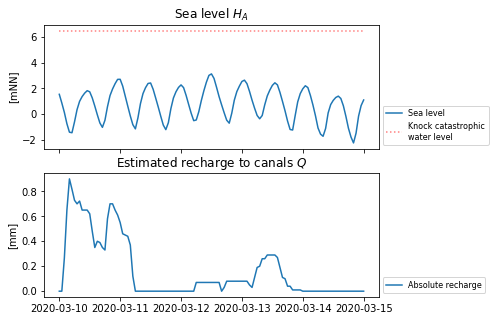

In [13]:
fig1, ax = plt.subplots(nrows = 2, sharex = True, figsize = [6,5])

ax[0].plot(tide/1000, label = "Sea level")
ax[0].plot([t1,t2],[6.5,6.5], color = "red", label = "Knock catastrophic\nwater level", alpha = 0.5, linestyle='dotted')
ax[0].legend(bbox_to_anchor=(1, 0), loc="lower left", ncol=1, fontsize = 8)

ax[0].set_ylabel("[mNN]")
ax[0].set_title("Sea level $H_A$")

if (recharge_vis == "absolute"):
    ax[1].plot(hourly_recharge, label = "Absolute recharge")
    ax[1].set_ylabel("[mm]")
    ax[1].legend(fontsize = 6)
else:
    ax[1].plot(np.cumsum(hourly_recharge), label = "Cumulative recharge")
    ax[1].legend(fontsize = 6)
    ax[1].set_ylabel("[mm]")
ax[1].set_title("Estimated recharge to canals $Q$")
ax[1].legend(bbox_to_anchor=(1, 0), loc="lower left", ncol=1, fontsize = 8)

#ax[1].xaxis.set_major_formatter(
#    mdates.ConciseDateFormatter(ax[1].xaxis.get_major_locator()))

### build plotly function

In [49]:
def sea_level(tide_data: pd.DataFrame, input_scale: float = 1/1000., knock_level: float = None, fig: go.Figure = None, row: int = 1, col: int = 1) -> go.Figure:
    # build a figure, if there is None
    if fig is None:
        fig = make_subplots(1, 1)

    # add tide data
    fig.add_trace(
        go.Scatter(x=tide_data.index, y=tide_data.values * input_scale, name='Sea level', line=dict(color='blue')), row=row, col=col
    )

    # add knock level
    if knock_level is not None:
        fig.add_hline(y=knock_level, name="Knock catastrophic water level", line=dict(color='red', dash='dash'), opacity=0.5)
        fig.add_annotation(x=0.5, y=0.95, xref="x domain", yref="y domain", text="Knock catastrophic water level", showarrow=False, font=dict(color='red', size=16))

    # update layout
    fig.update_layout(**{
        f'yaxis{row}': dict(title='Sea level [mNN]'),
        'paper_bgcolor': 'rgba(0,0,0,0)',
        'plot_bgcolor': 'rgba(0,0,0,0)',
        'legend': dict(orientation='h')
    })
    
    return fig

sea_level_base_data(tide_data=tide, knock_level=6.5)

In [ ]:
if (recharge_vis == "absolute"):
    ax[1].plot(hourly_recharge, label = "Absolute recharge")
    ax[1].set_ylabel("[mm]")
    ax[1].legend(fontsize = 6)
else:
    ax[1].plot(np.cumsum(hourly_recharge), label = "Cumulative recharge")
    ax[1].legend(fontsize = 6)
    ax[1].set_ylabel("[mm]")
ax[1].set_title("Estimated recharge to canals $Q$")
ax[1].legend(bbox_to_anchor=(1, 0), loc="lower left", ncol=1, fontsize = 8)


In [47]:
def canal_recharge(recharge_data: pd.DataFrame, cumsum: bool = False, fig: go.Figure = None, row: int = 1, col: int = 1) -> go.Figure:
    if fig is None:
        fig = make_subplots(1, 1)

    # handle cumsum
    if cumsum:
        recharge_data = np.cumsum(recharge_data)
        label = "Cumulative recharge"
    else:
        label = "Absolute recharge"

    # build the plot
    fig.add_trace(
        go.Scatter(x=recharge_data.index, y=recharge_data.values, name=label, line=dict(color='blue')),
        row=row, col=col
    )

    # update layout
    fig.update_layout(**{
        f'yaxis{row}': dict(title='Recharge [mm]'),
        'paper_bgcolor': 'rgba(0,0,0,0)',
        'plot_bgcolor': 'rgba(0,0,0,0)',
        'legend': dict(orientation='h')
    })
    
    return fig

canal_recharge(recharge_data=hourly_recharge, cumsum=False)

In [48]:
fig = make_subplots(2, 1)

fig = sea_level(tide_data=tide, knock_level=6.5, fig=fig, row=1, col=1)
fig = canal_recharge(recharge_data=hourly_recharge, cumsum=False, fig=fig, row=2, col=1)

fig